# IDOVEN Challenge Notebook - Jaime Cortón González

## Index

* Introduction
* Libraries import
* Data Loading 
* Data Exploration
* Data Visualization
* Extra
* Learned lessons
* References

## Introduction

### 12 lead ECG Context

In this database we are dealing with 12-lead ECG signals. As the name indicates this ECG is conformed of 12 different signals thet capture specific electric pulses between different strategically selected parts:

* **BIPOLAR LIMB LEADS:**
    * **Lead I)** records the electrical activity between the right arm (-) and left arm (+)

    * **Lead II)** records the electrical activity between the right arm (-) and left leg (+)

    * **Lead III)** records the electrical activity between the left arm (-) and left leg (+)


* **UNIPOLAR LIMB LEADS:**
    * **aVR)** records the electrical activity of the heart from a perspective looking towards the right arm

    * **aVL)** records the electrical activity of the heart from a perspective looking towards the left arm

    * **aVF)** records the electrical activity of the heart from a perspective looking towards the left leg
    

* **(PRECORDIAL) UNIPOLAR CHEST LEADS:**
    * **V1)** records the electrical activity of the heart from the fourth intercostals space, right sterna border.

    * **V2)** records the electrical activity of the heart from the fourth intercostals space, left sterna border.

    * **V3)** records the electrical activity of the heart from a position between V2 and V4.

    * **V4)** records the electrical activity of the heart from a position in the left mid-clavicular line.

    * **V5)** records the electrical activity of the heart from the left anterior axillary line.

    * **V6)** records the electrical activity of the heart from the left mid-axillary line.

The 12-lead ECG is used to detect various heart conditions, such as arrhythmias, ischemia, and infarction. It provides a comprehensive view of the heart's electrical activity, allowing healthcare providers to diagnose and treat heart conditions accurately.

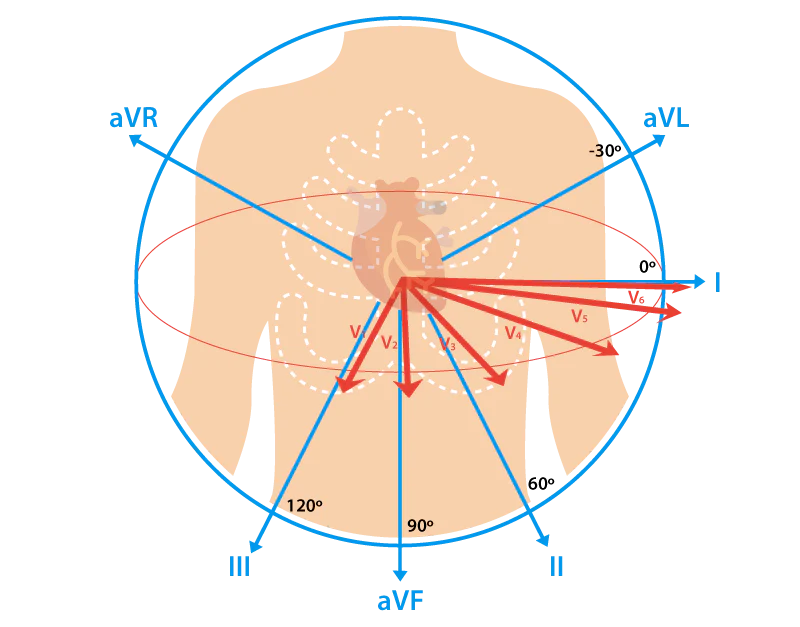
**Figure 1.** 12-Lead ECG Illustration

### A priori data description:

We have a dataset that consists on 2 main folders (**records100** and **records500**) containing the low resolution or high resolution files depending on the sampling frequency (100 for the ls and 500 for the hs). 

Appart from that, we also have 2 .csv files, one containing general information of each ecg like the patient_id, age, sex, nurse id (**ptbxl_database.csv**) and the other containing the list of diagnosis with its corresponding code and details (**scp_statements.csv**).

There is also a .py file with a dummmy example on how to charge the dataset (**example_physionet.py**). The rest of the files are not relevant for our study case and are mainly Licenses, formalities and metadata. A more detailed explanation of the data will be done below.

## Import libraries, ownership declaration and contact info

In [56]:
__author__="Jaime Cortón González"
__email__ ="corton35jaime@gmail.com"

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import ast
import wfdb
from wfdb import processing
import neurokit2 as nk
from scipy.signal import find_peaks, butter, lfilter

from utils import *

## Data loading

In [57]:
# Select your data loading method:

# 0 = you have already the data downloaded
# 1 = you want to download the full data directly
# 2 = you want to download the zip file

load_opt = 0   

if load_opt == 1:
    !wget -r -N -c -np https://physionet.org/files/ptb-xl/1.0.2/
    path = 'physionet.org/files/ptb-xl/1.0.2/'

elif load_opt == 2:
    !curl -o dataset.zip "https://physionet.org/static/published-projects/ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.2/"
    !unzip -qn dataset.zip
    path = 'ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.2/'

else:
    # If you already have the data just modify the path line below:
    path = '/home/victus-linux/Documentos/Proyectos_Git/IDOVEN_Challenge/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.2/'
    print(f'Dataset already downloaded, setting path to {path}')


Dataset already downloaded, setting path to /home/victus-linux/Documentos/Proyectos_Git/IDOVEN_Challenge/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.2/


In [58]:
# LOading data following the example_physionet.py file
# Load General Data
sampling_rate = 100

Y = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

X = load_raw_data(Y, sampling_rate, path)

# Load scp_statements.csv for diagnostic aggregation
agg_df = pd.read_csv(path+'scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

# Apply diagnostic superclass
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)

# Split data into train and test
test_fold = 10
val_fold  = 9

# Train
X_train = X[np.where( (Y.strat_fold != test_fold) | (Y.strat_fold != val_fold))]
y_train = Y[(Y.strat_fold != test_fold) | (Y.strat_fold != test_fold)].diagnostic_superclass
# Val
X_val = X[np.where(Y.strat_fold == val_fold)]
y_val = Y[(Y.strat_fold == val_fold)].diagnostic_superclass
# Test
X_test = X[np.where(Y.strat_fold == test_fold)]
y_test = Y[Y.strat_fold == test_fold].diagnostic_superclass

In [59]:
print(Y.keys()) # With this we can see all the keys of the Y dataframe, you can see that it is a very detailed annotation
Y.head()

Index(['patient_id', 'age', 'sex', 'height', 'weight', 'nurse', 'site',
       'device', 'recording_date', 'report', 'scp_codes', 'heart_axis',
       'infarction_stadium1', 'infarction_stadium2', 'validated_by',
       'second_opinion', 'initial_autogenerated_report', 'validated_by_human',
       'baseline_drift', 'static_noise', 'burst_noise', 'electrodes_problems',
       'extra_beats', 'pacemaker', 'strat_fold', 'filename_lr', 'filename_hr',
       'r_peaks', 'RS-LVH', 'S12-LVH', 'R56-LVH', 'QRS-LVH', 'LI-LVH',
       'SLI-LVH', 'QRS-CLBB', 'ST-ELEV-MI', 'ST-DEPR-MI', 'Q-ISC',
       'Q-ISC-QPeak', 'Q-ISC-V2V3', 'Q-ISC-RPeak', 'STRAIN', 'MI-ALL',
       'diagnostic_superclass'],
      dtype='object')


,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,...,QRS-CLBB,ST-ELEV-MI,ST-DEPR-MI,Q-ISC,Q-ISC-QPeak,Q-ISC-V2V3,Q-ISC-RPeak,STRAIN,MI-ALL,diagnostic_superclass
ecg_id,,,,,,,,,,,,,,,,,,,,,
1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,sinusrhythmus periphere niederspannung,...,False,False,False,False,False,False,False,False,False,[NORM]
2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,sinusbradykardie sonst normales ekg,...,False,False,False,False,False,False,False,False,False,[NORM]
3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,sinusrhythmus normales ekg,...,False,False,False,False,False,False,False,False,False,[NORM]
4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,sinusrhythmus normales ekg,...,False,False,False,False,False,False,False,False,False,[NORM]
5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,sinusrhythmus normales ekg,...,False,False,False,False,False,False,False,False,False,[NORM]


## Data exploration

Before switching to the visualization of the ecg it is important to study the annotation data that give us valuable insights about the signal.

By executing the cell below we can see all the possible combinations over the 5 Superclases (A single patient can present several conditions at the same time). According to the official documentation (https://physionet.org/content/ptb-xl/1.0.2/), the 5 classes are the following:

1. **[NORM]**: 	Normal ECG

2. **[MI]**: 	    Myocardial Infarction

3. **[STTC]**: 	ST/T Change

4. **[CD]**: 	    Conduction Disturbance

5. **[HYP]**: 	Hypertrophy

From that plot we can extract the following information:

- The Myocardial Infarction is highly related with Conduction Disturbances since they are the most abundant combined diagnoses along the whole dataset.

- Hypertrophy diagnosed together with a ST/T Change is even more abundant than Hypertrophy diagnosis on it's own.

- Like most of the Healthcare datasets, the data is unbalanced towards the Normal/Healthy individual ([NORM] Superclass alone is the most common diagnosis on this dataset)

<Axes: title={'center': 'Superclasses count bar plot'}, ylabel='Count'>

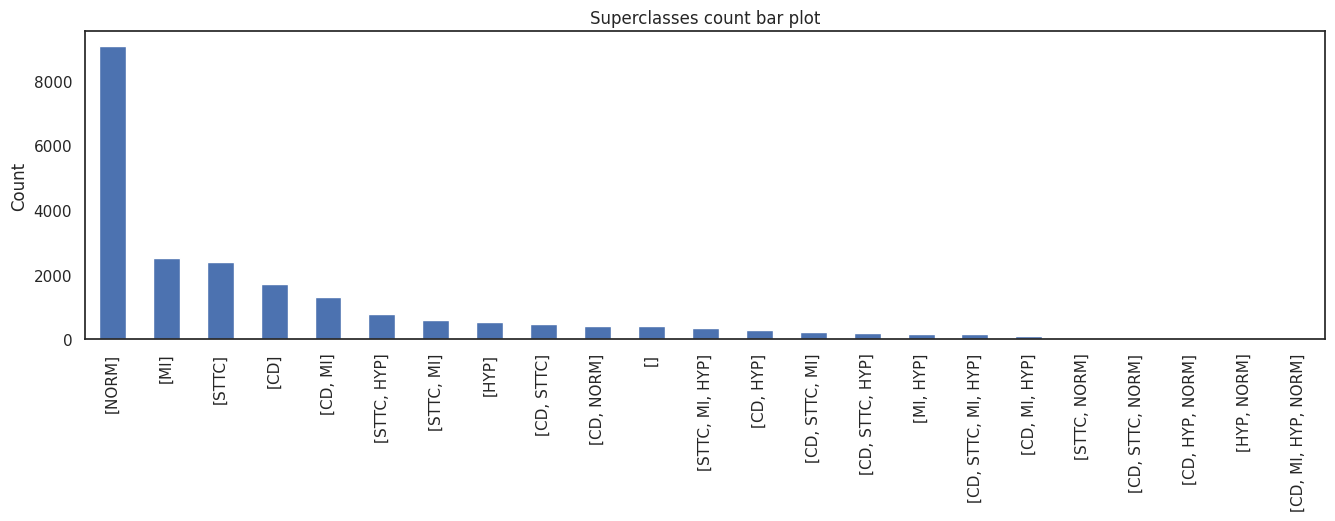

In [60]:
plt.figure(figsize=(16,4))
Y['diagnostic_superclass'].value_counts().plot.bar(Y['diagnostic_superclass'].value_counts().index, Y['diagnostic_superclass'].value_counts().values, rot=90, ylabel='Count',title='Superclasses count bar plot')

Let's start also with the classical histogram plot to visualize numerical data distribution from the .csv file (take into account that categorical data will not be included)

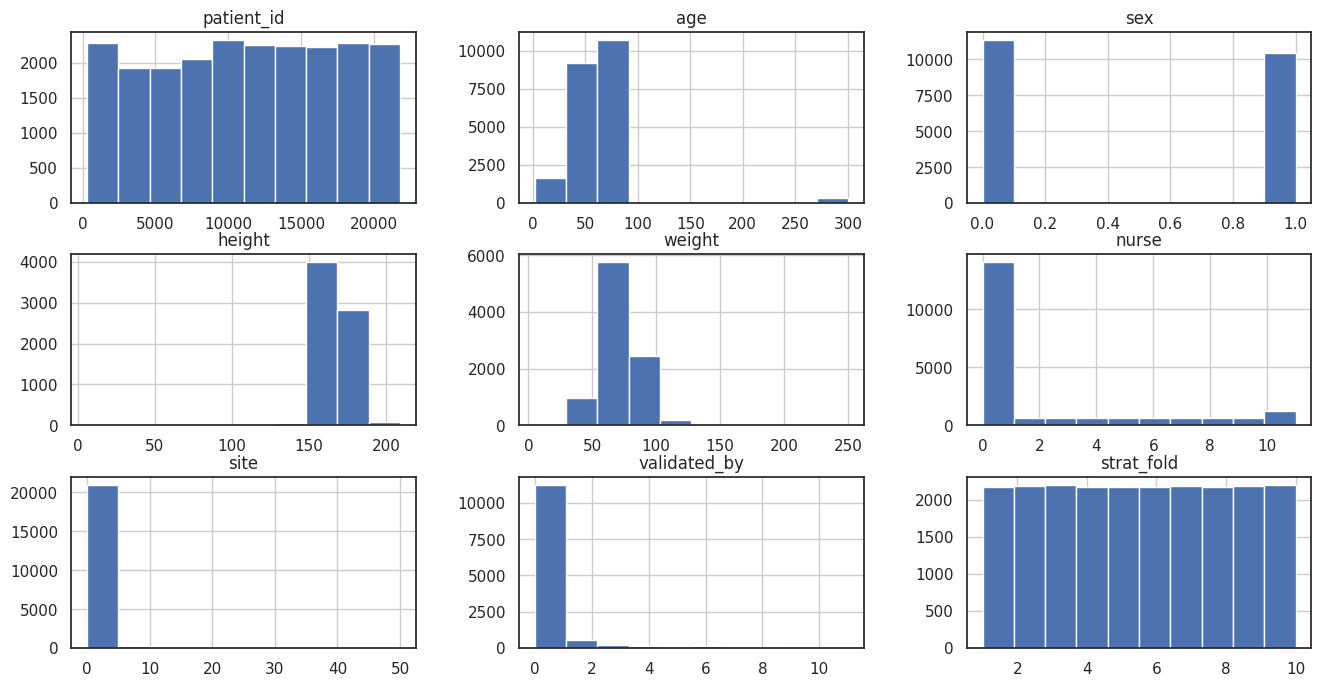

In [61]:
Y.hist(figsize=(16,8), bins=10)
_ = plt.show() # To hide unwanted message on the output

In [62]:
folder = 1               # This parameter will determine the first 2 digits of the folder: /records100/xx000/xx000_lr
sample = 10              # This will determine the sample taken: /records100/00000/00xxx_lr

record = wfdb.rdrecord(f'{path}/records100/{folder:02d}000/{folder:02d}{sample:03d}_lr', sampfrom = 100, smooth_frames=1)

#Let's play with the parameters of the signal using the rdrecord function (you can see that there is a lot of info embeded)

def evaluate_record(record):

    print(f'\nSignal fs : {record.fs}')
    print(f'\nSignal n_sig : {record.n_sig}')
    print(f'\nSignal file_name : {record.file_name}')
    print(f'\nSignal comments : {record.comments}')
    print(f'\nSignal length : {record.sig_len}')
    print(f'\nSignal units : {record.units}')
    
evaluate_record(record)


Signal fs : 100

Signal n_sig : 12

Signal file_name : ['01010_lr.dat', '01010_lr.dat', '01010_lr.dat', '01010_lr.dat', '01010_lr.dat', '01010_lr.dat', '01010_lr.dat', '01010_lr.dat', '01010_lr.dat', '01010_lr.dat', '01010_lr.dat', '01010_lr.dat']

Signal comments : []

Signal length : 900

Signal units : ['mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV']


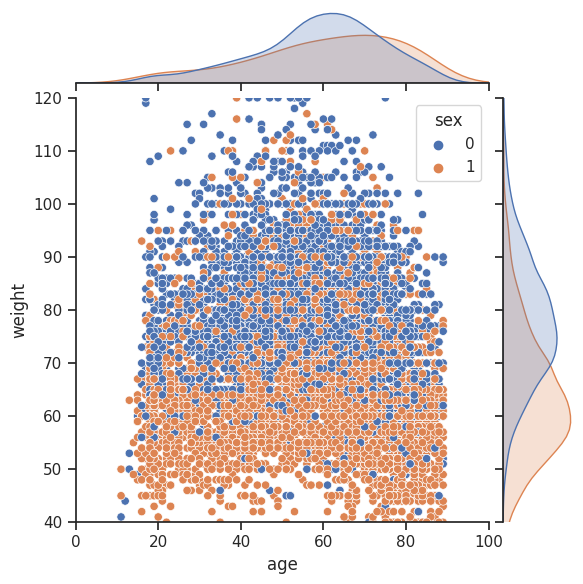

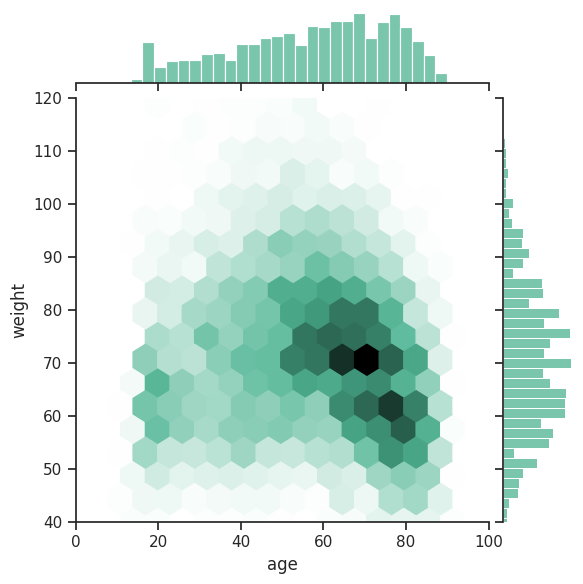

In [63]:
# Let's see the correlation over age weight and sex
sns.set_theme(style="ticks")

x = Y['age']
y = Y['weight']
sns.jointplot(x=x, y=y,xlim=(0,100),ylim=(40,120), color="#4CB391", hue=Y['sex'])

x = Y['age']
y = Y['weight']
sns.jointplot(x=x, y=y,xlim=(0,100),ylim=(40,120), kind="hex", color="#4CB391")
plt.show()

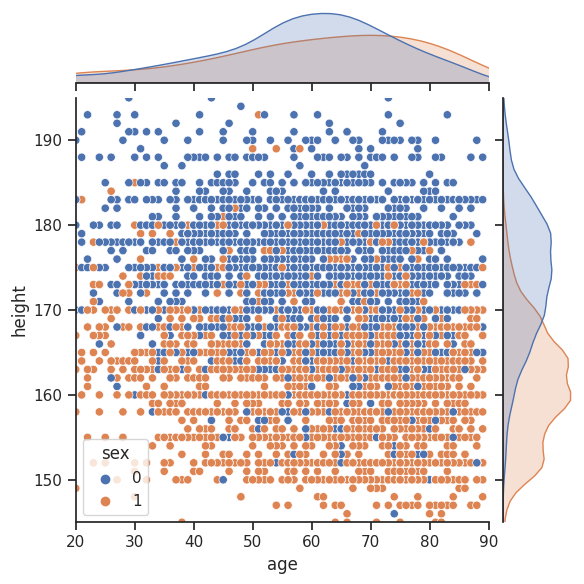

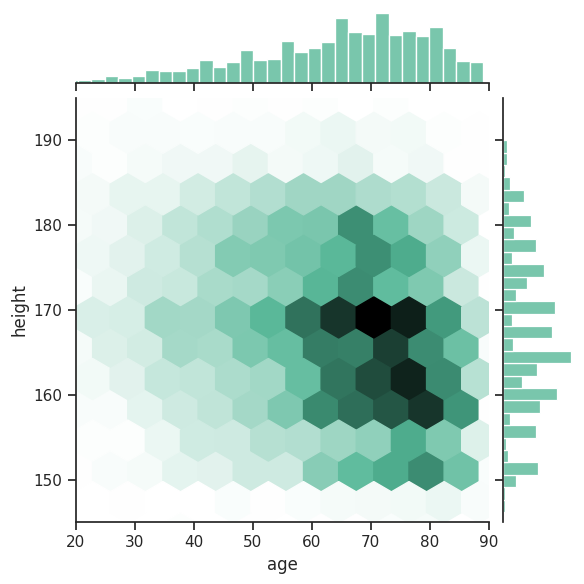

In [64]:
# Let's see the correlation over age weight and sex
sns.set_theme(style="ticks")

x = Y['age']
y = Y['height']
sns.jointplot(x=x, y=y,xlim=(20,90),ylim=(145,195), color="#4CB391", hue=Y['sex'])

x = Y['age']
y = Y['height']
sns.jointplot(x=x, y=y,xlim=(20,90),ylim=(145,195), kind="hex", color="#4CB391")
plt.show()

After the analysis of the variables age, sex, height and width it is a good moment to analyze more technical variables (binary variables) such as the following ones;

* **QRS-CLBB:** Abnormal QRS Complete Left Bundle Branch Block
* **ST-ELEV-MI:** Elevation of ST wave + Myocardial Infarction
* **ST-DEPR-MI:** Depresion of ST wave + Myocardial Infarction	
* **Q-ISC:** Abnormal Q wave + Ischemia
* **Q-ISC-QPeak:** Abnormal Q wave and Q Peak + Ischemia
* **Q-ISC-V2V3:** Abnormal Q wave, V2 lead and V3 lead + Ischemia
* **Q-ISC-RPeak:** Abnormal Q wave and R Peak + Ischemia

By analizing the correlation plot we can see the following things [DISCLAIMER: These variable are binary, True=1, False=0, indicating presence or absence of the condition, this plot is showing the correlation of this binary condition along the whole dataset]:

1. Q-ISC is obviously related with the rest of Ischemic flags (**Q-ISC-QPeak**, **Q-ISC-V2V3** and **Q-ISC-RPeak**)
2. Complete Left Bundle Branch Block is related with an abnormal ST wave and with Myocardial Infarction, so on analysis of future ECG's if one of the two conditions is encountered it would be good to do the adecuate analysis searching for the second condition.
3. Abnormal ST waves are not related with an abnormal ischemic R peak, 

<Axes: >

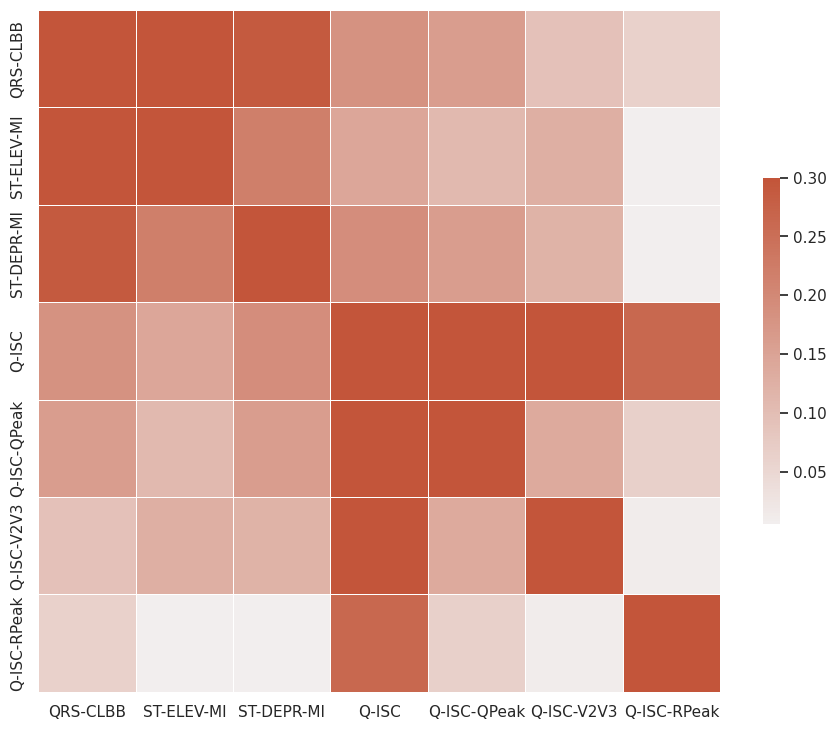

In [65]:

sns.set_theme(style="white")


d = pd.DataFrame(data=Y,
                 columns=['QRS-CLBB', 'ST-ELEV-MI', 'ST-DEPR-MI', 'Q-ISC', 'Q-ISC-QPeak', 'Q-ISC-V2V3', 'Q-ISC-RPeak'])

# Compute the correlation matrix
corr = d.corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Data visualization

Once we have processed data we can try to visualize the following things:

* 12-lead ECG plot
* Hearbeat of every sample
* Diagnosis + Visual reference
* QRS complex detection

Initially we can make use of the simple [WFDB library](https://wfdb.readthedocs.io/en/latest/) functions to do some initial plottings, even if the plottings are not properly placed you can have a quick visualization of the ecg's. Functions to try:

- rdann()
- rdsamp()
- plot_item()
- rdrecord()
- plot_wfdb()
- xqrs_detect()

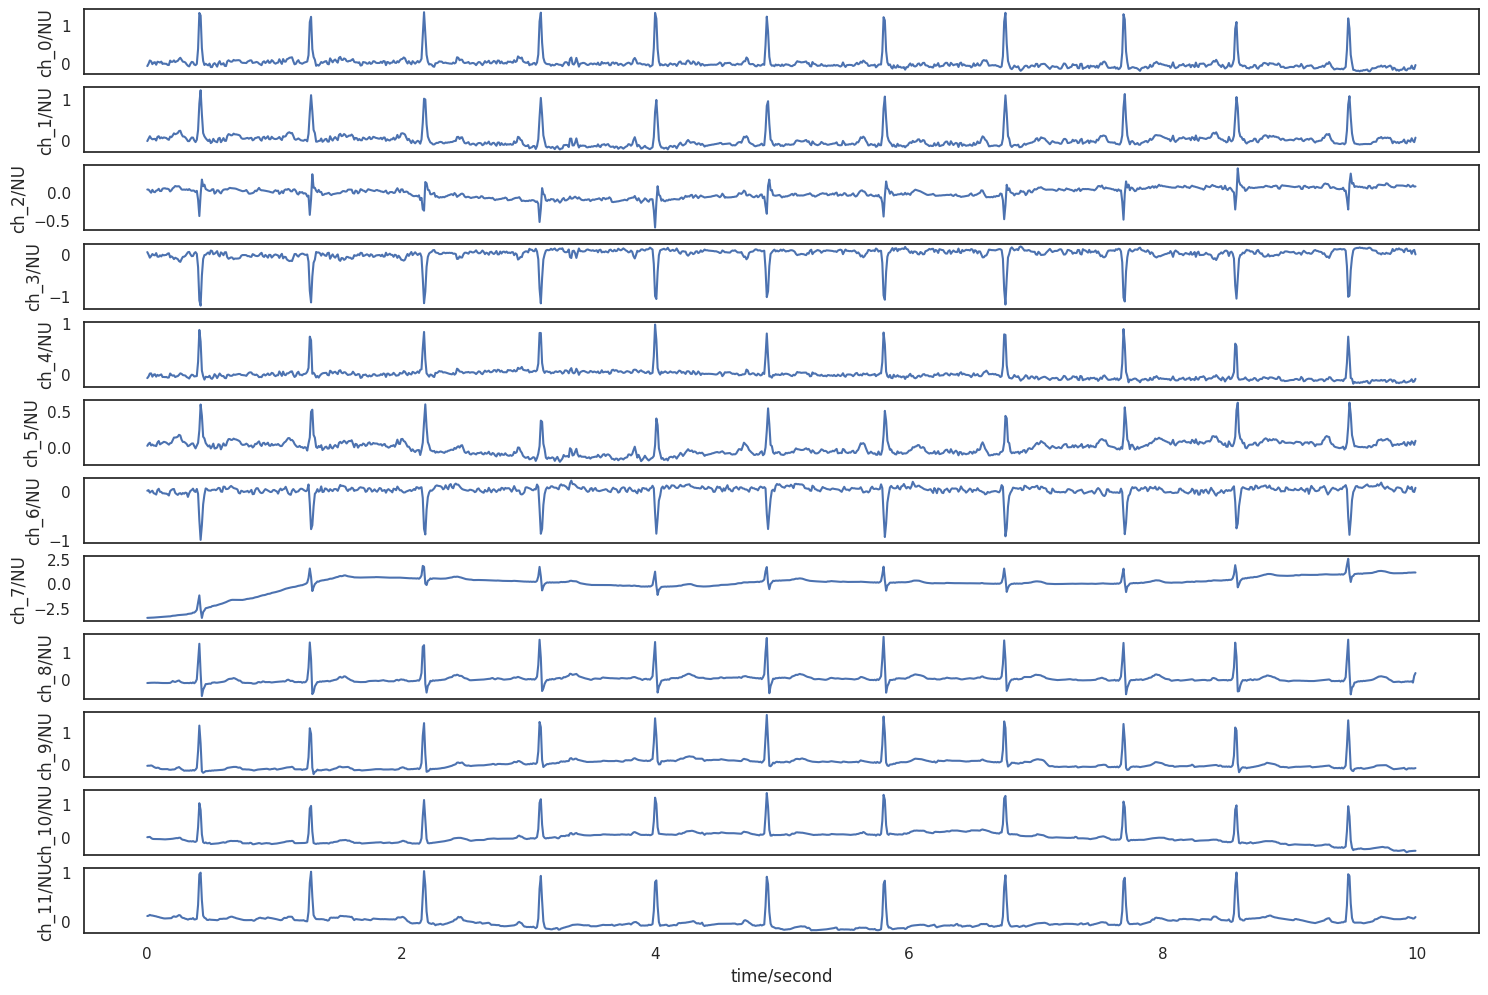

In [66]:
folder = 1               # This parameter will determine the first 2 digits of the folder: /records100/xx000/xx000_lr
sample = 10              # This will determine the sample taken: /records100/00000/00xxx_lr

annotation = wfdb.rdann(f'{path}/records100/{folder:02d}000/{folder:02d}{sample:03d}_lr', 'hea', shift_samps=True)
sig, fields = wfdb.rdsamp(f'{path}/records100/{folder:02d}000/{folder:02d}{sample:03d}_lr')

xs              = sig
ann             = annotation
fs              = fields['fs']
fs_target       = fs
resamp_ann_chan = 1

resamp_multi = wfdb.processing.resample_multichan(xs, ann, fs, resamp_ann_chan)

wfdb.plot_items(signal=sig,
                ann_sym=resamp_multi,
                time_units='seconds',
                sampling_freq = fs,
                figsize=(18, 12))

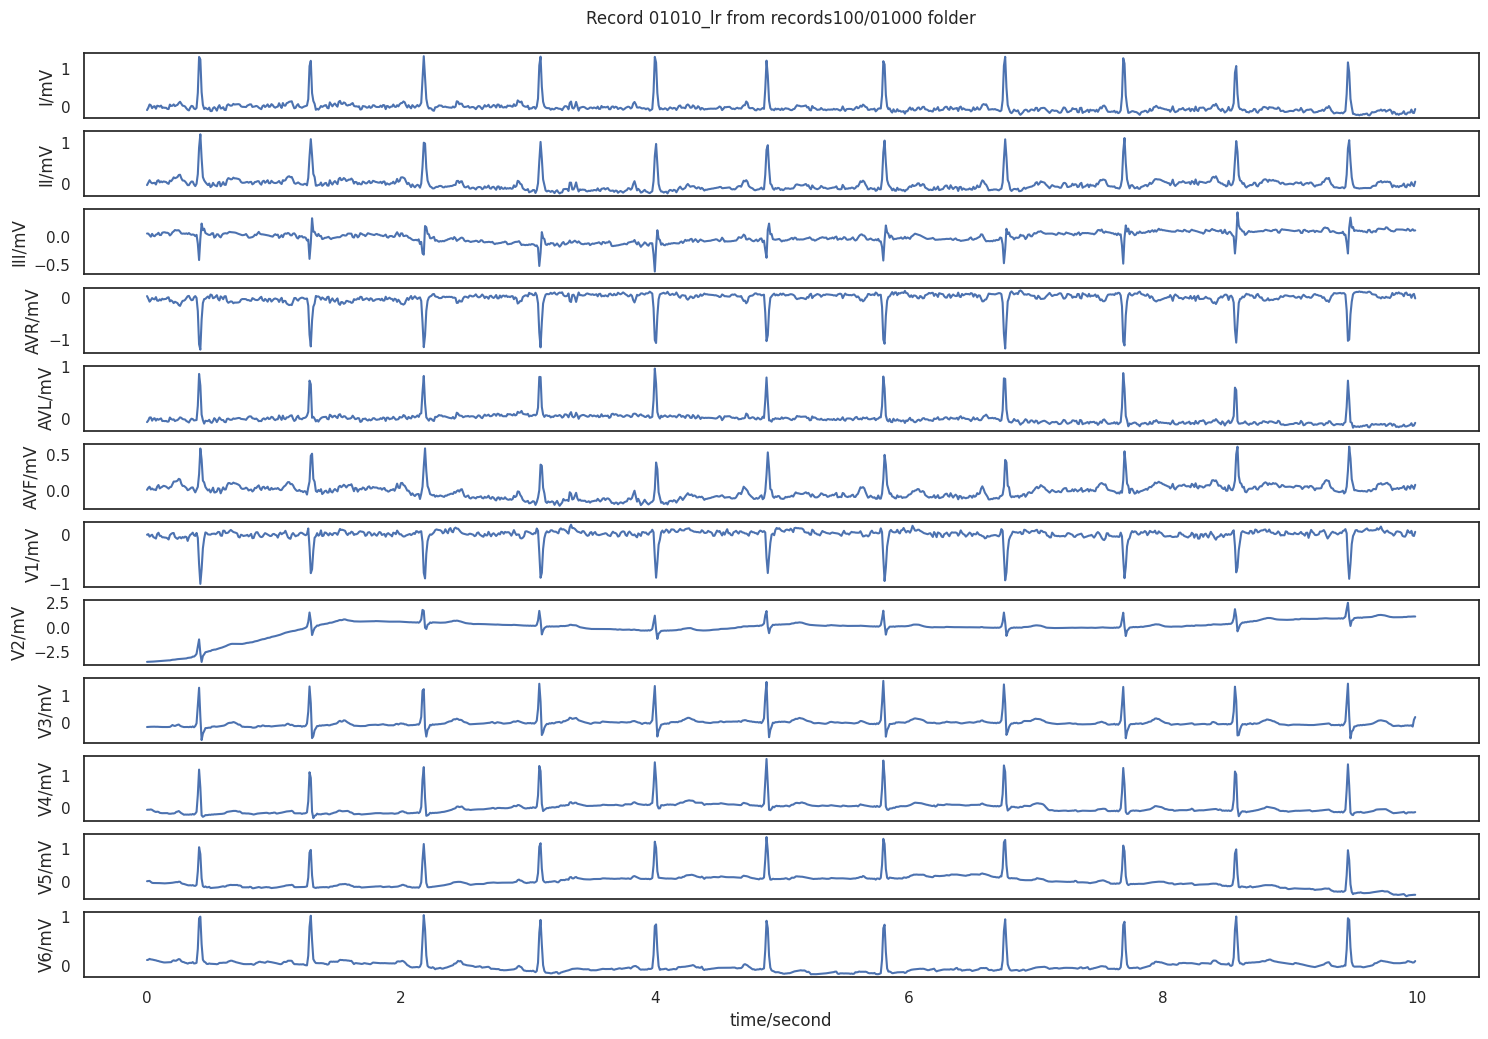

In [67]:
# Read a WFDB record. Plot all channels for certain patient

folder = 1               # This parameter will determine the first 2 digits of the folder: /records100/xx000/xx000_lr
sample = 10              # This will determine the sample taken: /records100/00000/00xxx_lr
record = wfdb.rdrecord(f'{path}/records100/{folder:02d}000/{folder:02d}{sample:03d}_lr')

wfdb.plot_wfdb(record=record, 
               title=f'Record {folder:02d}{sample:03d}_lr from records100/{folder:02d}000 folder\n',
               time_units='seconds',
               figsize=(18, 12))

{'fs': 100, 'sig_len': 1000, 'n_sig': 3, 'base_date': None, 'base_time': None, 'units': ['mV', 'mV', 'mV'], 'sig_name': ['I', 'II', 'III'], 'comments': []}


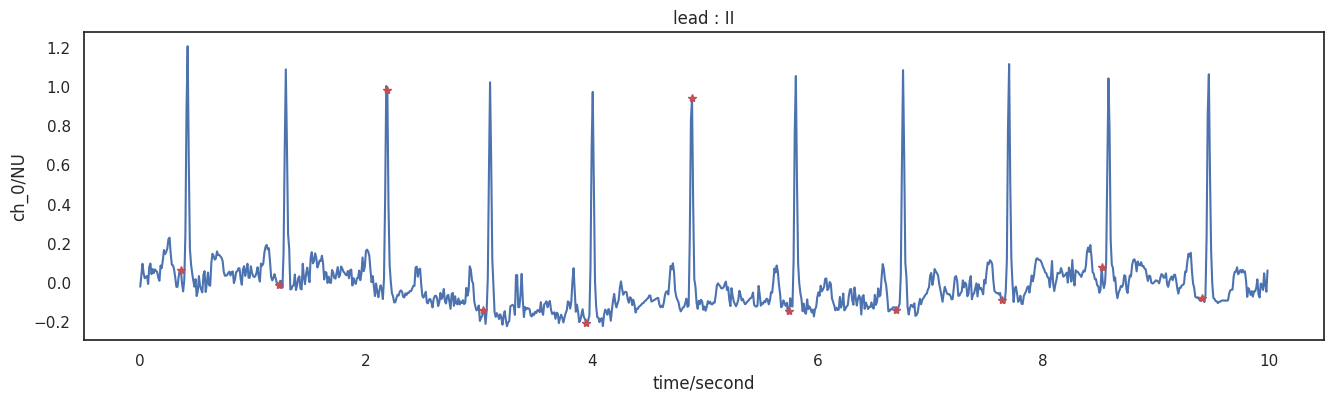

In [68]:
lead        = 1
sig, fields = wfdb.rdsamp(f'{path}/records100/{folder:02d}000/{folder:02d}{sample:03d}_lr', channels=[0,1,2])

print(fields)

xqrs_res = processing.xqrs_detect(sig=sig[:,lead],  fs=fields['fs'], verbose = False)

wfdb.plot_items(signal=sig[:,lead], fs=fields['fs'], ann_samp=[xqrs_res], figsize=(16,4), title=f'lead : {fields["sig_name"][lead]}', time_units="seconds")

WFDB is a wonderfull library but the plottings doesn't allow much customization (also preprocessing of the signal with functions like the qrs detection seems to be working bad), that's why I decided to switch libraries to have better results. Using [ipywidgets](https://ipywidgets.readthedocs.io/en/stable/) library as well as [IPython](https://ipython.org/) and coding the QRS and Heart Rate extraction using the [neurokit2](https://neuropsychology.github.io/NeuroKit/examples/ecg_delineate/ecg_delineate.html) library we can obtain a pretty compact and simple way of visualizing the maximum possible information. Having access to diagnosis and basic info together with the lead II ECG signal which typically is the most important in terms of QRS identification and heart rate computation.


ABOUT THIS CELL: To use the following cell just execute it, select the ECG ID that you are interested in and click on show results to see the detailed view and the main data displayed

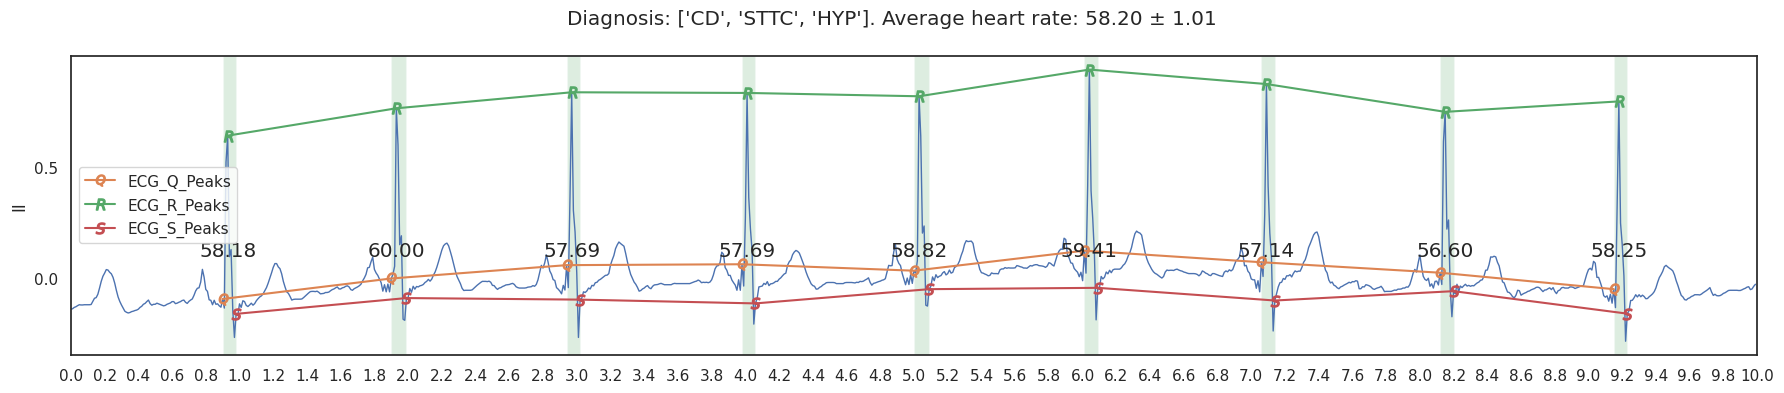

In [69]:
import ipywidgets as widgets
from matplotlib.ticker import MultipleLocator
from IPython.display import display, clear_output, Markdown

import warnings
warnings.filterwarnings('ignore')

# Simple Plotting
def single_plot(signal, ax, label):
    ax.xaxis.set_major_locator(MultipleLocator(sampling_rate * 200 // 1000))
    ax.xaxis.set_minor_locator(MultipleLocator(sampling_rate * 40 // 1000))
    ax.yaxis.set_major_locator(MultipleLocator(.5))
    ax.yaxis.set_minor_locator(MultipleLocator(.1))
    ax.set_ylabel(label)
    ax.plot(signal, linewidth=1)
    plt.axis('on')
    
    return ax

def peaksDetector(sample, title="", figsize=(20,8)):

    # get R peaks, heart rate and rest of peaks
    sampling_rate=100
    df, rpeaks = nk.ecg_process(sample[:,1], sampling_rate=sampling_rate)
    _, pqst = nk.ecg_delineate(sample[:,1], rpeaks, sampling_rate=sampling_rate, method="peak")
    peaks = {**rpeaks, **pqst}
    rate = nk.ecg_rate(df, sampling_rate=sampling_rate)
    avghr, stdhr = np.mean(rate), np.std(rate)
    
    # plot Lead II signal with its correspondent location
    fig = plt.figure(figsize=figsize, tight_layout=True)
    fig.suptitle(f"{title}. Average heart rate: {avghr:.2f} ± {stdhr:.2f}")
    ax = fig.subplots(subplot_kw={
        "xlim": [0, sample.shape[0]], 
        "xticklabels": [0] + [i/5 for i in range(1+5 * sample.shape[0] // sampling_rate)]
    })
    single_plot(sample[:, 1], ax, "II")
    
    # mark QRS complex
    for i in range(len(peaks["ECG_R_Peaks"])):
        start = peaks["ECG_Q_Peaks"][i] if peaks["ECG_Q_Peaks"][i] > 0 else peaks["ECG_R_Peaks"][i]
        end = peaks["ECG_S_Peaks"][i] if peaks["ECG_S_Peaks"][i] > 0 else peaks["ECG_R_Peaks"][i]
        ax.axvspan(start, end, facecolor="g", alpha=.2)
    
    # mark Q, R and S peaks
    for peak_type, marker in zip(["ECG_Q_Peaks", "ECG_R_Peaks", "ECG_S_Peaks"], ["$Q$", "$R$", "$S$"]):
        ax.plot(peaks[peak_type], [sample[i,1] if i > 0 else 0 for i in peaks[peak_type]], marker=marker, markersize=8, label=peak_type)
    ax.legend()
    
    # show heart rate at each peak
    for i in range(len(rate)):
        ax.text(peaks["ECG_R_Peaks"][i], .1, "{0:.2f}".format(rate[i]), ha="center", size="large")
    
    return fig, ax

users = widgets.Dropdown(
    options=list(set(Y.index)),
    value=8911,
    description='ECG-ID:',
    disabled=False)

dicti = {} # Initialize dictionary for holding {building(s): floor(s)} for each user.
# Button to display info about user
buttonuser_info = widgets.Button(description='Show Info')
outuser_info = widgets.Output()
def on_buttonuser_info_clicked(b):
    with outuser_info:
        clear_output()
        patient = Y.loc[[users.value]].patient_id.values[0]
        superclass = Y.loc[[users.value]].diagnostic_superclass.values[0]
        sex = Y.loc[[users.value]].sex.values[0]
        age = Y.loc[[users.value]].age.values[0]
        weight = Y.loc[[users.value]].weight.values[0]
        height = Y.loc[[users.value]].height.values[0]
        report = Y.loc[[users.value]].report.values[0]
        QRSCLBB = Y.loc[[users.value]]["QRS-CLBB"].values[0]
        STELEVMI = Y.loc[[users.value]]["ST-ELEV-MI"].values[0]
        STDEPRMI = Y.loc[[users.value]]["ST-DEPR-MI"].values[0]
        QISC = Y.loc[[users.value]]["Q-ISC"].values[0]
        QISCQPeak = Y.loc[[users.value]]["Q-ISC-QPeak"].values[0]
        QISCV2V3 = Y.loc[[users.value]]["Q-ISC-V2V3"].values[0]
        QISCRPeak = Y.loc[[users.value]]["Q-ISC-RPeak"].values[0]

        # display, the information in Markdown to make it look better.
        display(Markdown('''For **Ecg ID {}**, corresponding to **Patient_ID: {}**. \n
----------------------------------------------------------------
- **Diagnosed as** {}.
- **Sex:** {}  ,   **Age:** {}.
- **Weight:** {}, **Height:** {}.
- **(Could be in German) Report:** {}.
- **QRS-CLBB** = {}.
- **ST-ELEV-MI**: {},  **ST-DEPR-MI**: {}.
- **Q-ISC**: {}, **Q-ISC-QPeak**: {}, **Q-ISC-V2V3**: {}, **Q-ISC-RPeak** {}.
        '''.format(users.value, int(patient),superclass,"Male" if sex else "Female", int(age), weight, height, report, QRSCLBB, STELEVMI, STDEPRMI, QISC, QISCQPeak, QISCV2V3, QISCRPeak)))
        peaksDetector(X[users.value], title=f"Diagnosis: {superclass}", figsize=(18,4))

# Links button: buttonuser_info to its output function      
buttonuser_info.on_click(on_buttonuser_info_clicked)
display(widgets.VBox([users, buttonuser_info, outuser_info]))

Previous cell is useful for visualizing the main info of the patient, but typically doctors will look at the complete 12-lead signal, on the following cell I will be defining the function for that:

In [70]:
def complete_plot(sample, title=""):

    labels = ["I", "II", "III", "aVL","aVR", "aVF", "V1", "V2", "V3", "V4", "V5", "V6"]
    order = range(len(labels))
        
    subplot_kw = {"xticklabels": [], "yticklabels": [], "xlim": [0, sample.shape[0]]}
    fig = plt.figure(figsize=(18,10), tight_layout=True)
    fig.suptitle(title)
    axes = fig.subplots(6, 2, sharex=True, subplot_kw=subplot_kw)
    
    for i in order: # Plot signal on a simple 6 rows and 2 columns format
        signal = sample[:, i]
        single_plot(signal, axes[abs(i)%6, abs(i)//6], labels[i])
    
    return fig, axes

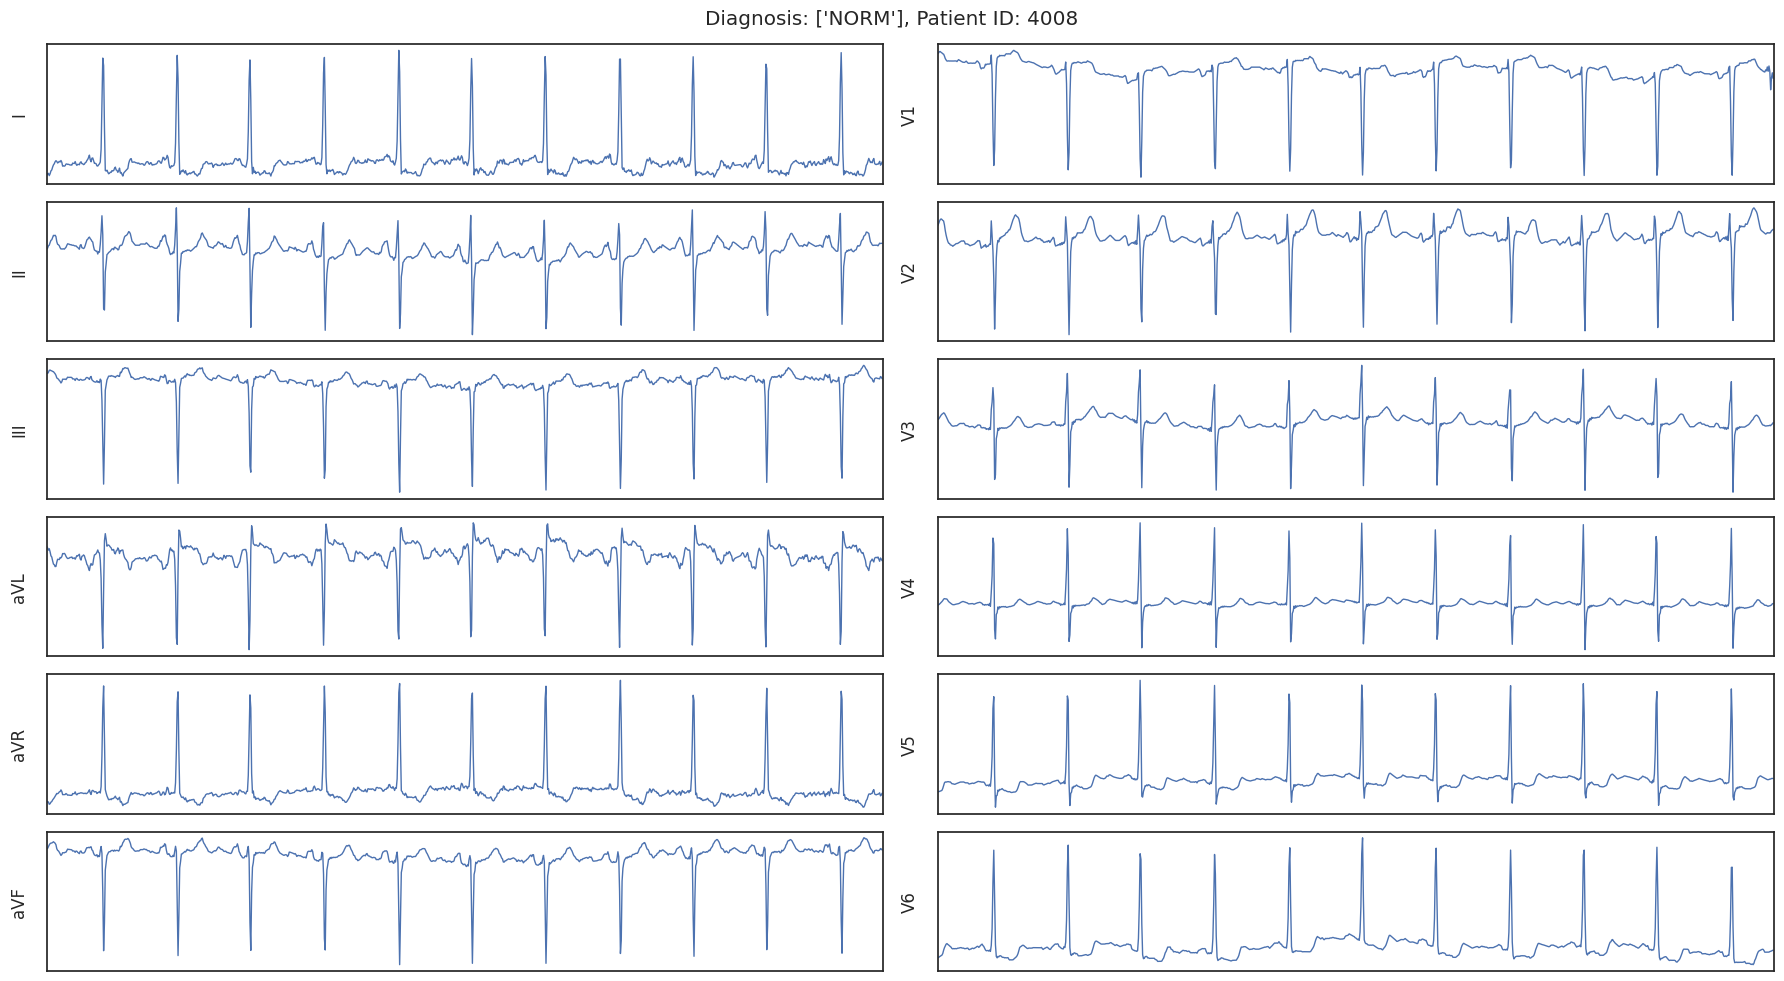

In [71]:
ecg_id = 1000

complete_plot(X_train[ecg_id], title=f"Diagnosis: {Y.loc[[ecg_id]].diagnostic_superclass.values[0]}, Patient ID: {int(Y.loc[[ecg_id]].patient_id.values[0])}")
plt.show()

## Extra

After plotting the main visualizations I decided to do some fourier trials to see the influence of basic filtering of the signal. On the figure below you can see that a classical highpass filter is able to get rid of the baseline distortion of the signal (since it is typically a low frequency distortion)

Shape of training set (patients, data, leads) = (21801, 1000, 12)
Shape of training set (patients,) = (19603,)

Shape of validation set (patients, data, leads) = (2183, 1000, 12)
Shape of validation set (patients,) = (2183,)

Shape of test set (patients, data, leads) = (2183, 1000, 12)
Shape of test set (patients,) = (2183,)


Text(0, 0.5, 'Amplitude [mV]')

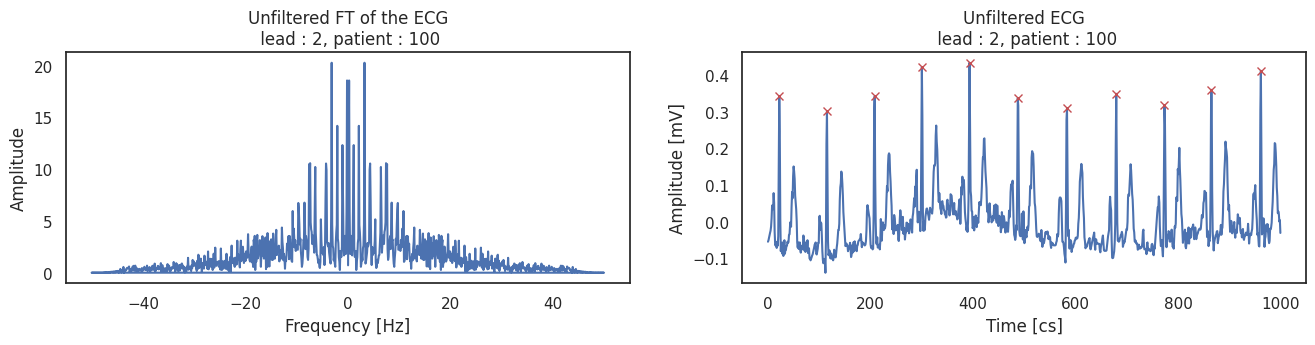

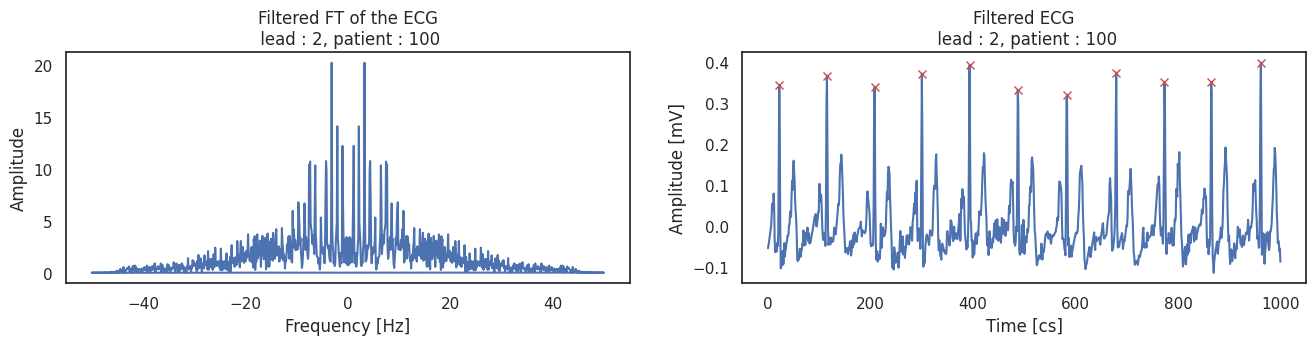

In [72]:
print(f'Shape of training set (patients, data, leads) = {np.shape(X_train)}')
print(f'Shape of training set (patients,) = {np.shape(y_train)}\n')
print(f'Shape of validation set (patients, data, leads) = {np.shape(X_val)}')
print(f'Shape of validation set (patients,) = {np.shape(y_val)}\n')
print(f'Shape of test set (patients, data, leads) = {np.shape(X_val)}')
print(f'Shape of test set (patients,) = {np.shape(y_val)}')

lead        = 2                                                      # Change to show a different lead (from 1 to 12)
patient     = 100                                                    # Change to show a different patient (check patient channel size to see the limit on previous print)
signal      = X_train[0,:,lead-1]                                    # Choose signal to plot
max_time    = np.shape(signal)[0]/sampling_rate 
time_steps  = np.linspace(0, max_time, np.shape(X_train[0,:,0])[0])  # Readjust x axis for temporal coordinates

peaks, _    = find_peaks(signal, prominence=0.3)                     # Dummy example on how to extract the R peaks

f = np.abs(np.fft.fft(signal))
freq_steps = np.fft.fftfreq(np.shape(signal)[0], d=1/sampling_rate)

plt.figure(figsize=(16, 3))
plt.subplot(1,2,1)
plt.plot(freq_steps, f)
plt.title(f'Unfiltered FT of the ECG\n lead : {lead}, patient : {patient}')
plt.xlabel("Frequency [Hz]")
plt.ylabel("Amplitude")
plt.subplot(1,2,2)
plt.plot(signal)
plt.plot(peaks, signal[peaks], "xr")
plt.title(f'Unfiltered ECG\n lead : {lead}, patient : {patient}')
plt.tick_params(axis='x', which='major')
plt.xlabel('Time [cs]')
plt.ylabel('Amplitude [mV]')

# Now lets apply a simple filter to see how baseline distortion affects the visualization

filtered_sig = highpass(signal, sampling_rate, 0.30)
f            = np.abs(np.fft.fft(filtered_sig))
freq_steps   = np.fft.fftfreq(np.shape(filtered_sig)[0], d=1/sampling_rate)
peaks, _     = find_peaks(filtered_sig, prominence=0.3)                     # Dummy example on how to extract the R peaks

plt.figure(figsize=(16, 3))
plt.subplot(1,2,1)
plt.plot(freq_steps, f)
plt.title(f'Filtered FT of the ECG\n lead : {lead}, patient : {patient}')
plt.xlabel("Frequency [Hz]")
plt.ylabel("Amplitude")
plt.subplot(1,2,2)
plt.plot(filtered_sig)
plt.plot(peaks, filtered_sig[peaks], "xr")
plt.title(f'Filtered ECG\n lead : {lead}, patient : {patient}')
plt.tick_params(axis='x', which='major')
plt.xlabel('Time [cs]')
plt.ylabel('Amplitude [mV]')


On the following cell I tryed to make use of the already given annotation of the r_peaks, but either the location is incorrect or I was not able to interpret it correctly, that's why I said that the WFDB Library has a lot of potential, but I was not able to extract the maximum out of it due to the time.

(1000,)


Text(0, 0.5, 'Amplitude [mV]')

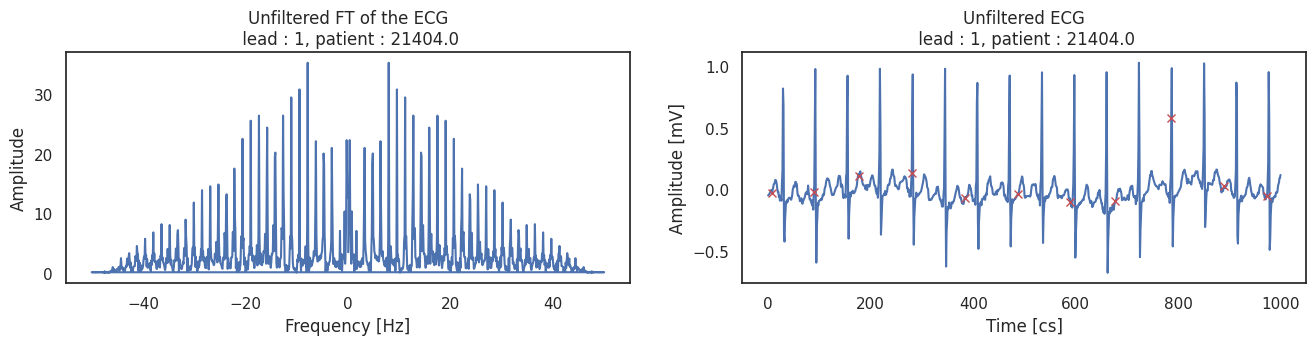

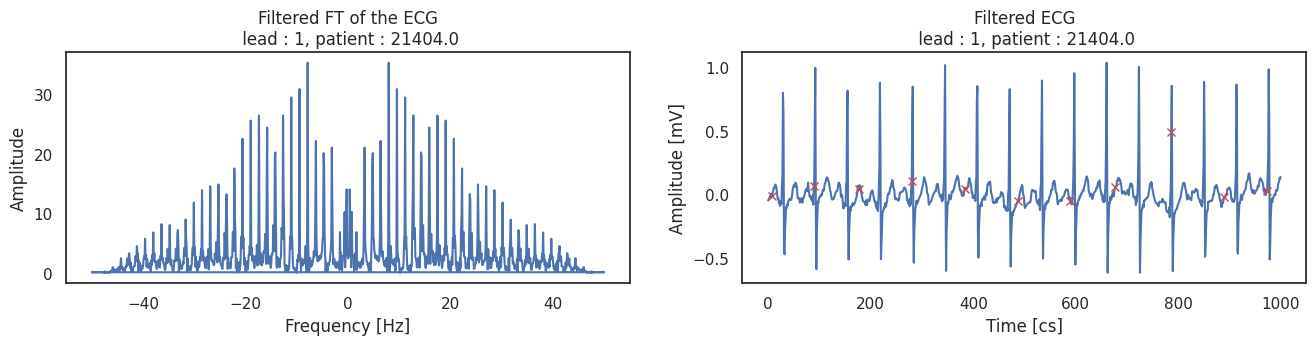

In [73]:
lead        = 1                                                      # Change to show a different lead (from 1 to 12)
ecg_id      = 100                                                    # Change to show a different patient (check patient channel size to see the limit on previous print)
signal      = X[ecg_id,:,lead]                                       # Choose signal to plot
print(np.shape(signal))
metadata    = Y.loc[ecg_id,:]  

peaks       = Y.loc[patient,:]['r_peaks']                            # Dummy example on how to extract the R peaks
peaks       = [int(x) for x in peaks.strip()[1:-1].split()]          # Convert peaks string into an integer list

f = np.abs(np.fft.fft(signal))
freq_steps = np.fft.fftfreq(np.shape(signal)[0], d=1/sampling_rate)

plt.figure(figsize=(16, 3))
plt.subplot(1,2,1)
plt.plot(freq_steps, f)
plt.title(f'Unfiltered FT of the ECG\n lead : {lead}, patient : {metadata["patient_id"]}')
plt.xlabel("Frequency [Hz]")
plt.ylabel("Amplitude")
plt.subplot(1,2,2)
plt.plot(signal)
plt.plot(peaks, signal[peaks], "xr")
plt.title(f'Unfiltered ECG\n lead : {lead}, patient : {metadata["patient_id"]}')
plt.xlabel('Time [cs]')
plt.ylabel('Amplitude [mV]')

# Now lets apply a simple filter to see how baseline distortion affects the visualization

filtered_sig = highpass(signal, sampling_rate, 0.30)
f            = np.abs(np.fft.fft(filtered_sig))
freq_steps   = np.fft.fftfreq(np.shape(filtered_sig)[0], d=1/sampling_rate)

plt.figure(figsize=(16, 3))
plt.subplot(1,2,1)
plt.plot(freq_steps, f)
plt.title(f'Filtered FT of the ECG\n lead : {lead}, patient : {metadata["patient_id"]}')
plt.xlabel("Frequency [Hz]")
plt.ylabel("Amplitude")
plt.subplot(1,2,2)
plt.plot(filtered_sig)
plt.plot(peaks, filtered_sig[peaks], "xr")
plt.title(f'Filtered ECG\n lead : {lead}, patient : {metadata["patient_id"]}')
plt.xlabel('Time [cs]')
plt.ylabel('Amplitude [mV]')


##  Learned lessons:

### In general

1. It is always important to know the data that you are working with, before jumping to play it is always good to have a deep initial analysis using plots and visual representations to have some initial insights about the problem that you are dealing with.

2. Scheduling is always important, you have a task to accomplish and the first thing to do is to divide the goal into smaller steps to have a smooth path to follow towards that goal.

3. Interpretation of an ecg can be hard if you  don't the proper representation of the signal, so make sure you use the proper libraries to detect correctly all the important peaks and waves to facilitate clinicians their diagnosis and interpretation job.

### In detail

It is interesting to see how the leads and its strategically placed position can give us valuable clues to detect certain conditions, having an abnormal ST-T segment/wave (remember that this wave is almost flat in normal scenarios 'the plateau phase', in which the majority of the myocardial cells had gone through depolarization but not repolarization) can come from very different scenarios. Either an ischemia is causing an abnormal repolarization that changes the ST-T wave or a bundle branch block is causing an abnormal depolarization that will cause at the same time an abnormal repolarization that will generate an abnormal ST-T wave. I like to see the ecg analysis as some short of chain reaction in which once you find something in the data (let's call it a link of the chain) you have to follow it through the path discarding the non suitable options.

Another interesting detail is the non-ecg related data, it is always important to read the documentation to discard data that might add biases to your models (for instance there are some age values that are set to 300 because some issue of data protection of the elder people that if you don't notice will add incredible outliers to the dataset).

It is also key to know the relationship between the signals components, for example, if we have an abnormal/altered QRS complex due to an abnormal depolarization it is very likely that we will see an altered ST-T segment because of the abnormal repolarization caused by the previous abnormal depolarization, in the end diagnosis is searching the cause of abnormalities (in this case abnormalities of the ecg signal), so to avoid misleading conclussions it is important to know the conexions between the fragments.

### Extra (What I would do with more time)

- First of all, I would like to introduce an idea that I would like to comment with you. It is very common to analyze ECGs with neural networks based on temporal/sequential information like RNNs, LSTMs, transformer and many other state-of-the-art architectures but I've never seen somebody using computer vision models. Considering that the way a doctor interprets the ecg is through the eyes and through visual information of the signal, it is strange to me that the research is not directed into this area more often. It is true that analyzing the discrete ecg signal as a temporal series has a lot of advantages like the precision on voltage values analysis, the meaningful Fourier domain analysis possibility and many other things, but I think that having the computer vision models of nowadays joined with the text-to-image models there is a big path for research (It also opens the possibility of combining ecg signal with Cardiac MRI analysis and its relationship). It might be a good idea to find a common ground between ecg visual analysis together with the written clinical history.

- Having more time I would have make good use of the already done training, test and validation data partition. It was clear to me that you were expecting some algorithm development using ecg's but as stayed on the DISCLAIMER section, I didn't have much time. Ideally I would have set CUDA usage (typically on torch since CUDA 12 for tensorflow/keras is giving problems due to unreleased sublibraries) to run things on my personal GPU. I would have generated a better user interface to make doctors interpretations simpler considering the no-coding typical background, something simple like tkinter would be okey for the moment. I think I didn't update GitHub as often as I should have done, but again, time constraints.

- Also, having more time I would have documented everything better, I would have followed more in detail PEP 8 style guide to have a more readable code. I would have read more documentation regarding not only ecg fundamentals topics but also regarding python libraries and functions like wfdb (I think the library has a huge potential, also neurokit2 library)

- Finally I would like to say that you can contact me to have any kind of discussion, I'll be happy to set a meeting. Please feel free to make any kind of comment regarding the code, or the README.md file. Thank you for the opportunity.

## References:

* [ECG waves interpretation and origin](https://ecgwaves.com/topic/ecg-normal-p-wave-qrs-complex-st-segment-t-wave-j-point/)
* [Seaborn visualization](https://jakevdp.github.io/PythonDataScienceHandbook/04.14-visualization-with-seaborn.html)
* [WFDB documentation](https://wfdb.readthedocs.io/en/latest/)
* [Widgets on Jupyter Notebooks](https://towardsdatascience.com/bring-your-jupyter-notebook-to-life-with-interactive-widgets-bc12e03f0916)
* [Database documentation detail](https://physionet.org/content/ptb-xl/1.0.2/)